In [3]:
# import relevant library
import numpy as np
import math
import statistics
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import sys
import os
import random
random.seed()
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Supporting functions

In [ ]:
def is_full_object_visible(image):
    """
    Ensure that all non-zero pixels remain within the visible frame.
    
    Args:
        image (numpy.ndarray): 2D array representing the image.

    Returns:
        bool: True if the object is fully visible, False otherwise.

    UNCHANGED
    """
    # Find the bounding box of non-zero pixels
    rows = np.any(image > 0, axis=1)
    cols = np.any(image > 0, axis=0)
    visible_rows = np.where(rows)[0]
    visible_cols = np.where(cols)[0]

    if len(visible_rows) == 0 or len(visible_cols) == 0:
        return False  # Object not visible at all

    # Check if the bounding box touches the frame
    min_row, max_row = visible_rows[0], visible_rows[-1]
    min_col, max_col = visible_cols[0], visible_cols[-1]

    return (min_row > 0 and max_row < image.shape[0] and
            min_col > 0 and max_col < image.shape[1])

In [ ]:
def augment_and_resample(X_class, Y_class, n_samples, datagen):
    """
    Augment and resample the dataset to ensure required samples are fully visible.
    
    Args:
        X_class: Original image 
        Y_test: Corresponding label
        n_samples: number of augmented samples
        datagen: DataGenerator to deform images

    Returns:
        X_aug (numpy.ndarray): Array of augmented training images.
        Y_aug (numpy.ndarray): Array of corresponding class labels

    UNCHANGED
    """
    X_aug, Y_aug = [], []
    max_attempts_per_sample = 20  # Maximum retries per sample
    attempts = 0

    while len(X_aug) < n_samples:
        # Ensure we are treating a single image as a batch
        original_images = np.expand_dims(X_class, axis=0)  # Adds an extra dimension
        original_labels = np.expand_dims(Y_class, axis=0)  # Adds an extra dimension

        # Generate augmented images in batches
        augmented_images = datagen.flow(
            np.expand_dims(original_images, axis=-1),
            original_labels,
            batch_size=len(original_images),
            shuffle=False
        )

        for batch_images, batch_labels in augmented_images:
            for i in range(len(batch_images)):
                if len(X_aug) >= n_samples:
                    break  # Stop once we have enough samples

                # Check if the image is fully visible
                image = batch_images[i, :, :, 0]
                if is_full_object_visible(image):
                    X_aug.append(image)
                    Y_aug.append(batch_labels[i])
                else:
                    attempts += 1
                    # Fallback to original image after max_attempts_per_sample
                    if attempts > max_attempts_per_sample:
                        if is_full_object_visible(original_images[i]):
                            X_aug.append(original_images[i])
                            Y_aug.append(original_labels[i])
                            attempts = 0  # Reset attempts for next sample
            
            if len(X_aug) >= n_samples:
                break  # Stop generating more images

    return np.array(X_aug), np.array(Y_aug)


EMPIRICAL DISTANCE

In [ ]:
def l2(X):
    """
    Args:
        X: Image defined as square matrix

    Returns:
        Squared L2 norm of the image

    ADDED
    """
    
    d = len(X)              #find resolution of image
    d_X = 0            
    for i in range(d):
        for j in range(d):
            d_X += (X[i][j])**2 
    d_X = d_X/(d**2)
    return(d_X)

# Data generation

## Single template

In [ ]:
def generate_data(n_train, n_test, num1, num2,im1 = 0,im2 = 0):
    """
    Generates the training and test data sets by augmenting images of two different classes from 
    MNIST.
    
    Args:
        n_train (int): Number of training samples per class
        n_test (int): Number of test samples per class
        num1 (int): class label of class 1 (digit between 0 to 9)
        num2 (int): class label of class 2 (digit between 0 and 0)
        im1,im2 (int): optional, positions of images to be selected as templates
        
        pixels: A 2D binary array (e.g., image) where non-zero elements represent pixels of the object.
        
    Returns:
        X_train_aug (list of numpy.ndarray): Augmented training images.
        Y_train_aug (numpy.ndarray): Corresponding labels for training images.
        X_test_aug (list of numpy.ndarray): List of augmented test images.
        Y_test_aug (numpy.ndarray): Corresponding labels for test images.

    UNCHANGED
    """

    #--------------DATA LOADING AND FILTERING--------------

    # Load MNIST data
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Filter data for the two specific classes (using only one image per class)
    filter1 = np.where(Y_train == num1)[0]
    filter2 = np.where(Y_train == num2)[0]

    #----------------------------

    #--------------DEFINE POSSIBLE TRANSFORMS AND TEMPLATE IMAGES--------------

    # Choose the selected templated from each class for both training and testing
    X_class1, Y_class1 = X_train[filter1[im1]], Y_train[filter1[im1]]
    X_class2, Y_class2 = X_train[filter2[im2]], Y_train[filter2[im2]]

    # Augment data using the same image for both training and testing
    datagen_train = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[1.0, 2.0],
        brightness_range=[0.8, 1.5],
    )
    
    datagen_test = ImageDataGenerator(
        width_shift_range=0.2,  # Different augmentation for test set
        height_shift_range=0.2,
        zoom_range=[1.0, 1.5],
        brightness_range=[0.7, 1.2],
    )

    #----------------------------

    #--------------GENERATE IMAGES--------------

    # Augment the same image for both training and testing
    X_train_aug1, Y_train_aug1 = augment_and_resample(X_class1, Y_class1, n_train, datagen_train)
    X_train_aug2, Y_train_aug2 = augment_and_resample(X_class2, Y_class2, n_train, datagen_train)
    
    X_test_aug1, Y_test_aug1 = augment_and_resample(X_class1, Y_class1, n_test, datagen_test)
    X_test_aug2, Y_test_aug2 = augment_and_resample(X_class2, Y_class2, n_test, datagen_test)

    # Combine data from both classes for training and testing
    X_train_aug = np.concatenate([X_train_aug1, X_train_aug2])
    Y_train_aug = np.concatenate([Y_train_aug1, Y_train_aug2])
    X_test_aug = np.concatenate([X_test_aug1, X_test_aug2])
    Y_test_aug = np.concatenate([Y_test_aug1, Y_test_aug2])

    return X_train_aug, Y_train_aug, X_test_aug, Y_test_aug

    #----------------------------

In [6]:
# Example usage:

X_train_aug, Y_train_aug, X_test_aug, Y_test_aug = generate_data(100, 20, 0, 1)

# Check generated sample sizes
print(f"Training samples generated: {len(X_train_aug)}")
print(f"Test samples generated: {len(X_test_aug)}")


Training samples generated: 200
Test samples generated: 40


## Multiple templates

In [ ]:
def generate_data_mult(n_train, n_test, num1, num2, ntemp = 1,mask1 = [],mask2 = []):
    """
    Generates the training and test data sets by augmenting images of two different classes from 
    MNIST.
    
    Args:
        n_train (int): Number of training samples per class
        n_test (int): Number of test samples per class
        num1 (int): class label of class 1 (digit between 0 to 9)
        num2 (int): class label of class 2 (digit between 0 to 9)
        ntemp1 (int): number of template functions to be used from the first and second label
        mask1, mask2 (array of int): list of indices of template functions to be used for generating data, used for reproducability of results
        
    Returns:
        X_train_aug (list of numpy.ndarray): Augmented training images.
        Y_train_aug (numpy.ndarray): Corresponding labels for training images.
        X_test_aug (list of numpy.ndarray): List of augmented test images.
        Y_test_aug (numpy.ndarray): Corresponding labels for test images.
        dist: The estimated distance between the two chosen numbers.

    Note: Works also for having only one template, which is the default

    ADDED
    """

    #--------------PRELIMINARY COMPUTATIONS--------------

    n_train = math.ceil(n_train/ntemp)      #normalize by the number of templates to avoid generating too many samples
    n_test = math.ceil(n_test/ntemp)        #this produces an approximate bound due to rounding, thus we implement a break later

    # Load MNIST data
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Filter data for the two specific classes (using only one image per class)
    filter1 = np.where(Y_train == num1)[0]
    filter2 = np.where(Y_train == num2)[0]

    #Sample random templates from all possible templates
    if (mask1 == []) or (len(mask1) != ntemp):              #check if template indices were chosen and well defined, if not define template indices
        mask1 = random.sample(range(len(filter1)),ntemp)
    if (mask2 == []) or (len(mask2) != ntemp):
        mask2 = random.sample(range(len(filter2)),ntemp)

    #----------------------------

    #--------------DATA GENERATION--------------

    #Generate augmented data from one sample
    X_train_aug, Y_train_aug, X_test_aug, Y_test_aug = generate_data(n_train,n_test,num1,num2,im1=mask1[ntemp-1],im2=mask2[ntemp-1])
    X_train_aug_arr = (X_train_aug)
    Y_train_aug_arr = (Y_train_aug)
    X_test_aug_arr = (X_test_aug)    
    Y_test_aug_arr = (Y_test_aug)

    #Reiterate
    for i in range(ntemp-1):
        X_train_aug, Y_train_aug, X_test_aug, Y_test_aug = generate_data(n_train,n_test,num1,num2,im1=mask1[i],im2=mask2[i])
        X_train_aug_arr = np.append(X_train_aug_arr,X_train_aug,axis = 0)
        Y_train_aug_arr = np.append(Y_train_aug_arr,Y_train_aug)
        X_test_aug_arr = np.append(X_test_aug_arr,X_test_aug,axis = 0)
        Y_test_aug_arr = np.append(Y_test_aug_arr,Y_test_aug)

    #----------------------------

    return(X_train_aug_arr,Y_train_aug_arr,X_test_aug_arr,Y_test_aug_arr)


In [35]:
# Example usage:
num1 = 0
num2 = 1

X_train_aug, Y_train_aug, X_test_aug, Y_test_aug = generate_data_mult(100, 20, num1, num2, 4)

# Check generated sample sizes
print(f"Training samples generated: {len(X_train_aug)}")
print(f"Test samples generated: {len(X_test_aug)}")

Training samples generated: 200
Test samples generated: 40


# Empirical distance

In [ ]:
def emp_dist(n_total,num1,num2,ntemp = 1,mask1 = [],mask2 = []):
    """
    Computes empirical distance between two chosen digits
    
    Args:
        n_total: total number of images to be generated
        num1: choice of first digit
        num2: choice of second digit
        ntemp: number of templates per digit
        mask1/mask2: used for selecting templates for generating data, used for repeatability
        
    Returns:
        dist: the empirical distance computed using the newly twice augmented images

    ADDED
    """

    #--------------PRELIMINARY COMPUTATIONS--------------

    n = math.ceil(math.sqrt(n_total/ntemp))         #normalize by the number of templates to avoid generating too many templates
    
    datagen_emp_inv = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[0.5, 1.0],
        brightness_range=[1/1.5, 1/0.8],
    )

    # Load MNIST data
    (X, Y), (temp1,temp2) = mnist.load_data()

    # Filter data for the two specific classes (using only one image per class)
    filter1 = np.where(Y == num1)[0]
    filter2 = np.where(Y == num2)[0]

    #Sample random templates from all possible templates
    if (mask1 == []) or (len(mask1) != ntemp):              #check if template indices were chosen and well defined, if not define template indices
        mask1 = random.sample(range(len(filter1)),ntemp)
    if (mask2 == []) or (len(mask2) != ntemp):
        mask2 = random.sample(range(len(filter2)),ntemp)

    #----------------------------

    #--------------FIRST DATA GENERATION--------------

    #Generate augmented data from one sample
    X_aug, Y_aug, temp1, temp2 = generate_data(n,0,num1,num2,im1=mask1[ntemp-1],im2=mask2[ntemp-1])
    X_aug_arr = (X_aug)
    Y_aug_arr = (Y_aug)

    #Reiterate
    for i in range(ntemp-1):
        X_aug, Y_aug, temp1, temp2 = generate_data(n,0,num1,num2,im1=mask1[i],im2=mask2[i])
        X_aug_arr = np.append(X_aug_arr,X_aug,axis = 0)
        Y_aug_arr = np.append(Y_aug_arr,Y_aug)

    
    #----------------------------

    #Compute filter for our generated data
    filter_aug1 = np.where(Y_aug_arr == num1)[0]
    filter_aug2 = np.where(Y_aug_arr == num2)[0]

    #Split the generated data between the two numbers
    X_aug_arr1 = X_aug_arr[filter_aug1]
    X_aug_arr2 = X_aug_arr[filter_aug2]

    #--------------INVERSE TRANSFORM DATA GENERATION--------------

    #Generate inverse transforms for num1
    for i in range(len(X_aug_arr1)):
        X = X_aug_arr1[i]
        Y = num1                    #no need to read in Y_train_aug_arr1 as we only take images of class num1
        if i == 0:
            X_emp_aug_arr1,Y_emp_aug_arr1 = augment_and_resample(X, Y, n, datagen_emp_inv)
        else:
            X_emp_aug1,Y_emp_aug1 = augment_and_resample(X, Y, n, datagen_emp_inv)
            X_emp_aug_arr1 = np.append(X_emp_aug_arr1,X_emp_aug1,axis = 0)               # in Y_aug_arr2 as we only take images of class num2
            Y_emp_aug_arr1 = np.append(Y_emp_aug_arr1,Y_emp_aug1)
        if len(X_emp_aug_arr1) >= n_total:                      #as n is a rounded number we need to avoid sampling too many images
            break
    #for num2
    for i in range(len(X_aug_arr2)):
        X = X_aug_arr2[i]
        Y = num2                    #no need to read in Y_train_aug_arr2 as we only take images of class num2
        if i == 0:
            X_emp_aug_arr2,Y_emp_aug_arr2 = augment_and_resample(X, Y, n, datagen_emp_inv)
        else:
            X_emp_aug2,Y_emp_aug2 = augment_and_resample(X, Y, n, datagen_emp_inv)
            X_emp_aug_arr2 = np.append(X_emp_aug_arr2,X_emp_aug2,axis = 0)
            Y_emp_aug_arr2 = np.append(Y_emp_aug_arr2,Y_emp_aug2)
        if len(X_emp_aug_arr2) >= n_total:                      #as n is a rounded number we need to avoid sampling too many images
            break

    #----------------------------

    #--------------PRELIMINARY COMPUTATIONS--------------

    dist = sys.maxsize                      #initialize dist as maxsize to make sure any computed distance will be smaller
    d = len(X_emp_aug_arr1[0])                    #number of pixels per side used in our computation

    norms1 = [l2(x) for x in X_emp_aug_arr1]      #compute all l2 norms to avoid recomputing later
    norms2 = [l2(x) for x in X_emp_aug_arr2]

    #----------------------------

    #--------------COMPUTE DISTANCE--------------

    for i in range(len(X_emp_aug_arr1)):
        d_X1 = norms1[i]
        for j in range(len(X_emp_aug_arr2)):
            d_X2 = norms2[j]
            d_X1_X2 = l2(X_emp_aug_arr1[i]-X_emp_aug_arr2[j])/(max(d_X1,d_X2))
            if d_X1_X2 < dist:
                dist = d_X1_X2

    return(dist)

    #----------------------------

In [11]:
num1 = 0
num2 = 9
dist = emp_dist(100,num1,num2,4)
print("Distance between " + str(num1) + " and " +str(num2) + " = " + str(dist))

Distance between 0 and 9 = 0.346238020631813


In [9]:
num1 = 1
num2 = 7
dist = emp_dist(100,num1,num2,4)
print("Distance between " + str(num1) + " and " +str(num2) + " = " + str(dist))

Distance between 1 and 7 = 0.4074960752985813


In [10]:
num1 = 5
num2 = 0
dist = emp_dist(100,num1,num2,4)
print("Distance between " + str(num1) + " and " +str(num2) + " = " + str(dist))

Distance between 5 and 0 = 0.52266674202231


# Image visualisation

In [ ]:
def visualize_images(X_train, Y_train, X_test, Y_test, num1, num2, n_samples=5,title = ""):
    """
    Visualizes the first few images from the training and test sets for both classes.
    
    Args:
        X_train_aug (numpy.ndarray): Training images.
        Y_train_aug (numpy.ndarray): Corresponding labels for training images.
        X_test_aug (numpy.ndarray): Test images. 
        Y_test_aug (numpy.ndarray): Corresponding labels for test images.
        num1 (int): Class label of class 1 (digit between 0 to 9)
        num2 (int): class label of class 2 (digit between 0 and 0)
        n_samples (int): number of augmented images to be plotted per class
        title (str): Text to be added to the title of the plot
        
    Returns:
        None: Displays plots of the images.

    MODIFIED
    """

    # --------------COMPUTATIONS FOR FORMATTING--------------

    # Compute number of available images for each class of generated training data 
    train_class1_images = X_train[Y_train == num1]
    train_class2_images = X_train[Y_train == num2]

    # Compute number of available images for each class of generated testing data 
    test_class1_images = X_test[Y_test == num1]
    test_class2_images = X_test[Y_test == num2]

    # Compute how many rows we need and adjusted desired samples to not use more images than we have
    n_samples = min(n_samples,len(train_class1_images),len(train_class2_images),len(test_class1_images),len(test_class2_images))
    rownum = n_samples//5       #number of fully filled rows
    if n_samples%5 != 0:
        rownum += 1             #add 1 row if we have a row we would not fill entirely
    

    # --------------PLOTTING TRAINING DATA--------------

    # Dynamically resize plot to better fit our number of plots
    fig, ax = plt.subplots(int(rownum*2), min(5,n_samples), figsize=(min(5,n_samples)*2,int(rownum*2)*2),squeeze = False)

    # These arrays store randomly selected indices of images
    train_class1_to_show = random.sample(range(len(train_class1_images)),n_samples)
    train_class2_to_show = random.sample(range(len(train_class2_images)),n_samples)

    # Training images for class num1
    for i in range(min(n_samples, len(train_class1_images))):
        ax[i//5, i%5].imshow(train_class1_images[train_class1_to_show[i]].reshape(28, 28), cmap="gray")
        ax[i//5, i%5].set_title(f"Class {num1}")

    # Training images for class num2
    for i in range(min(n_samples, len(train_class2_images))):
        ax[rownum + i//5, i%5].imshow(train_class2_images[train_class2_to_show[i]].reshape(28, 28), cmap="gray")
        ax[rownum + i//5, i%5].set_title(f"Class {num2}")
        
    # Separate loop to go over all available (empty or used) suplots to remove x and y axis
    for i in range(2*rownum):
        for j in range(min(5,n_samples)):
            ax[i,j].axis('off')

    #Set desired title
    if title != "":
        fig.suptitle(title)

    plt.show()

    # ----------------------------

    # --------------PLOTTING TESTING DATA--------------

    # Dynamically resize plot to better fit our number of plots
    fig, ax = plt.subplots(int(rownum*2), min(5,n_samples), figsize=(min(5,n_samples)*2,int(rownum*2)*2),squeeze = False)

    # These arrays store randomly selected indices of images
    test_class1_to_show = random.sample(range(len(test_class1_images)),n_samples)
    test_class2_to_show = random.sample(range(len(test_class2_images)),n_samples)

    # Test images for class num1
    for i in range(min(n_samples, len(test_class1_images))):
        ax[i//5, i%5].imshow(test_class1_images[test_class1_to_show[i]].reshape(28, 28), cmap="gray")
        ax[i//5, i%5].set_title(f"Class {num1}")

    # Test images for class num2
    for i in range(min(n_samples, len(test_class2_images))):
        ax[rownum + i//5, i%5].imshow(test_class2_images[test_class2_to_show[i]].reshape(28, 28), cmap="gray")
        ax[rownum + i//5, i%5].set_title(f"Class {num2}")
    
    # Separate loop to go over all available (empty or used) suplots to remove x and y axis
    for i in range(2*rownum):
        for j in range(min(5,n_samples)):
            ax[i,j].axis('off')

    #Set desired title
    if title != "":
        fig.suptitle(title)

    plt.show()

    # ----------------------------

In [ ]:
def gen_and_vis(num1,num2,ntemp=1):
    """Used to generate and visualize data in one function, with computation of the empirical separation quantity
        using the same template
    
    INPUT
        num1,num2 (int): the two digits to be plotted
        ntemp (int): the number of templates to be used per class
        
    OUTPUT
        none, returns a plot

    ADDED    
    """
    # Load MNIST data
    (X, Y), (temp1,temp2) = mnist.load_data()

    # Filter data for the two specific classes (using only one image per class)
    filter1 = np.where(Y == num1)[0]
    filter2 = np.where(Y == num2)[0]
    mask1 = random.sample(range(len(filter1)),ntemp)
    mask2 = random.sample(range(len(filter2)),ntemp)
    X_train_aug, Y_train_aug, X_test_aug, Y_test_aug = generate_data_mult(100, 20, num1, num2, ntemp, mask1, mask2)
    dist = emp_dist(100,num1,num2,ntemp,mask1,mask2)
    visualize_images(X_train_aug, Y_train_aug, X_test_aug, Y_test_aug, num1, num2, n_samples=5,title = "Distance = " + str(dist))

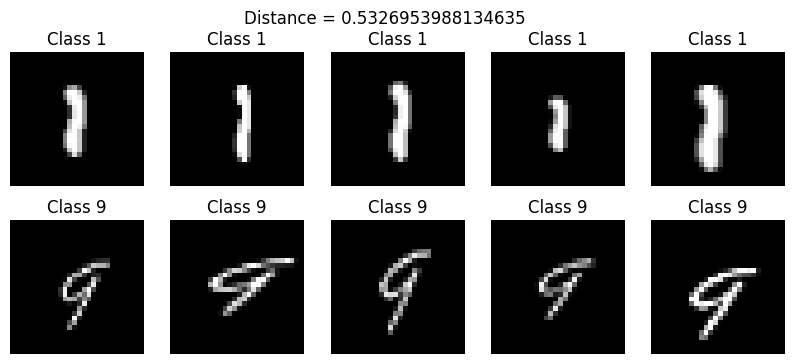

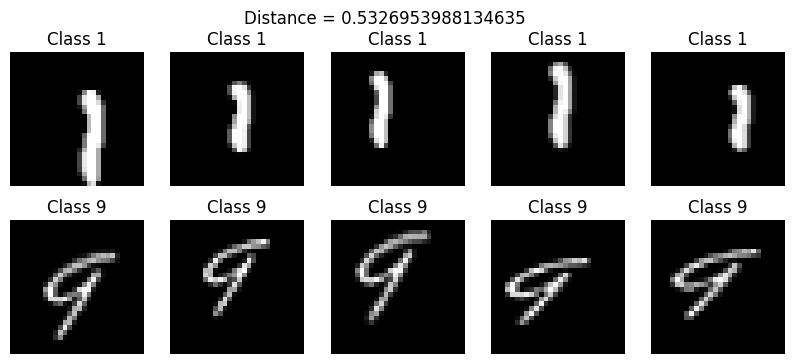

In [31]:
num1 = 1
num2 = 9
ntemp = 1
gen_and_vis(num1,num2,ntemp)

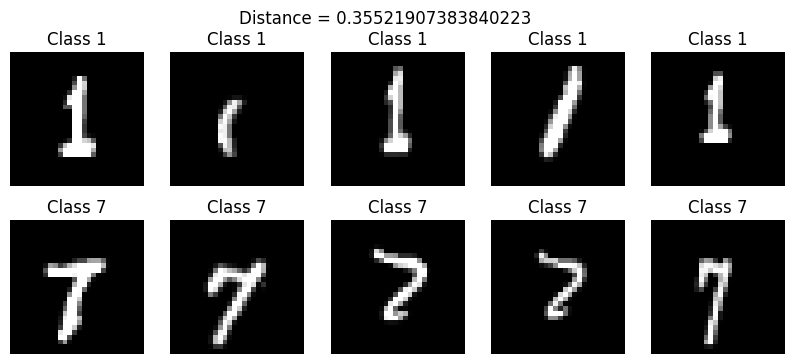

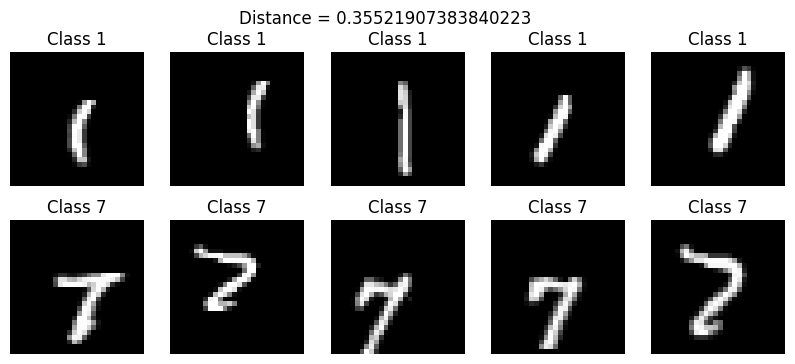

In [35]:
# Visualize the first 5 training and test images for both classes
num1 = 1
num2 = 7
ntemp = 4
gen_and_vis(num1,num2,ntemp)

# Convergence of empirical separation quantity

In [ ]:
def plot_emp_dist(sample_sizes,num1,num2,ntemp=1):
    """Creates a plot of empiricial separation quantity vs sample size
    
    INPUT
        sample_sizes (array of int): array of integers specifying the number of samples to be used
        num1,num2 (int): digits for which to compute the empirical separation quantity
        ntemp (int): number of templates

    OUTPUT
        none: returns plot and images generated with same template functions

    ADDED
    """

    #--------------SELECTING TEMPLATE FUNCTIONS--------------

    # Load MNIST data
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Filter data for the two specific classes (using only one image per class)
    filter1 = np.where(Y_train == num1)[0]
    filter2 = np.where(Y_train == num2)[0]

    #Sample random templates from all possible templates
    mask1 = random.sample(range(len(filter1)),ntemp)
    mask2 = random.sample(range(len(filter2)),ntemp)

    #----------------------------

    #--------------COMPUTING EMPIRICAL SEPARATION QUANITIES--------------

    Y = []
    for i in sample_sizes:
        Y += [emp_dist(i,num1,num2,ntemp,mask1=mask1,mask2=mask2)]

    #----------------------------

    #--------------PLOTTING--------------

    if ntemp == 1:
        plural = ""
    else:
        plural = "s"
    plt.plot(sample_sizes,Y)
    plt.title(f"Empirical distance between {num1} and {num2} for {ntemp} template"+plural)
    plt.xlabel("Sample size")
    plt.ylabel("Empirical distance")
    plt.show()

    #----------------------------

    #--------------SHOW TEMPLATES THAT WERE USED--------------

    X_train, Y_train, X_test, Y_test = generate_data_mult(5,5,num1,num2,ntemp,mask1,mask2)
    visualize_images(X_train, Y_train, X_test, Y_test, num1, num2, n_samples=5,title = "")

    #----------------------------

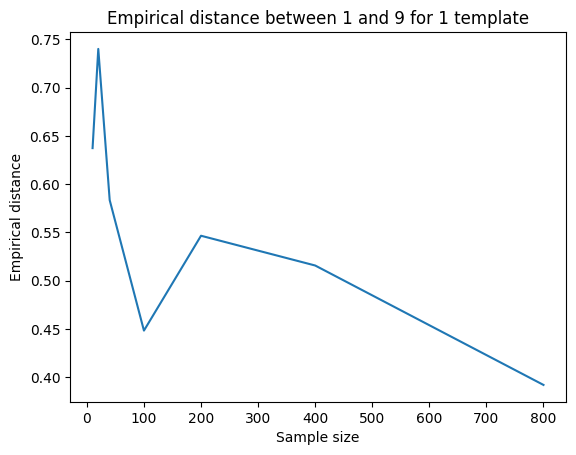

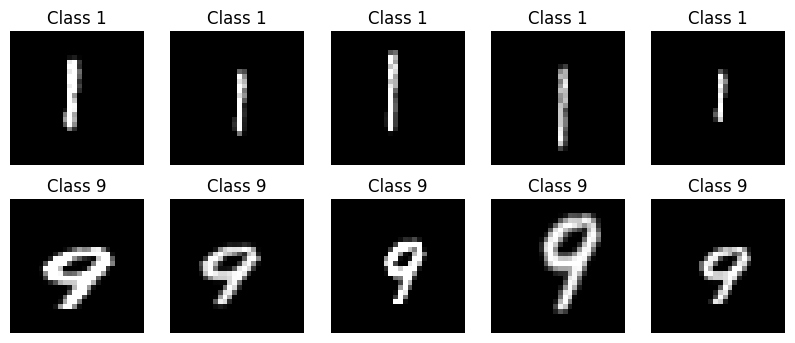

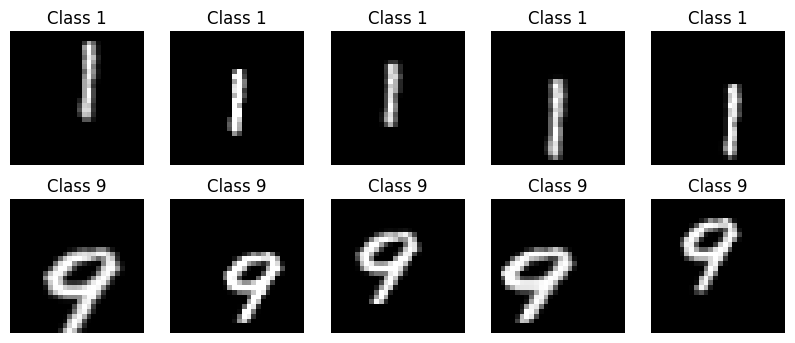

In [27]:
num1 = 1
num2 = 9
ntemp = 1
X = [10,20,40,100,200,400,800]
plot_emp_dist(X,num1,num2,ntemp)

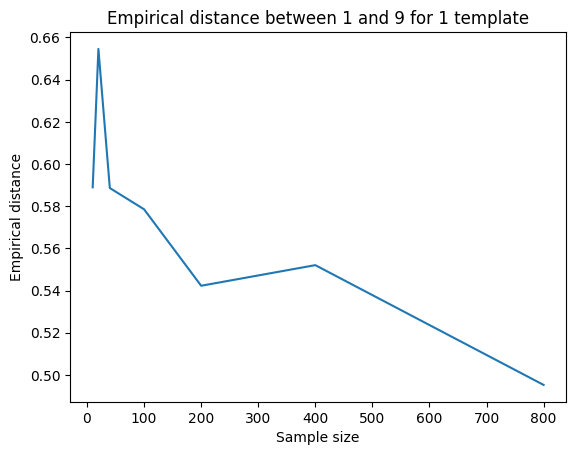

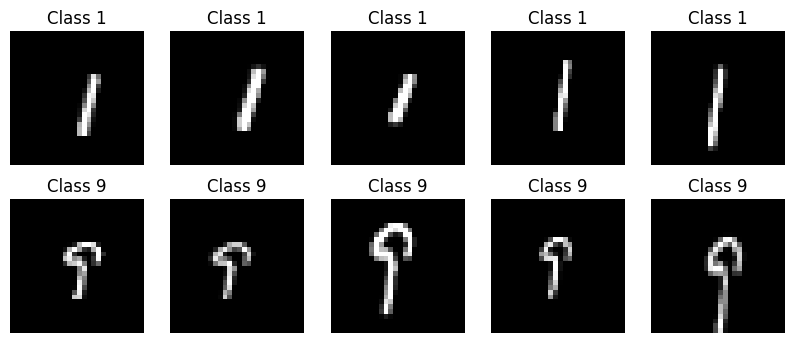

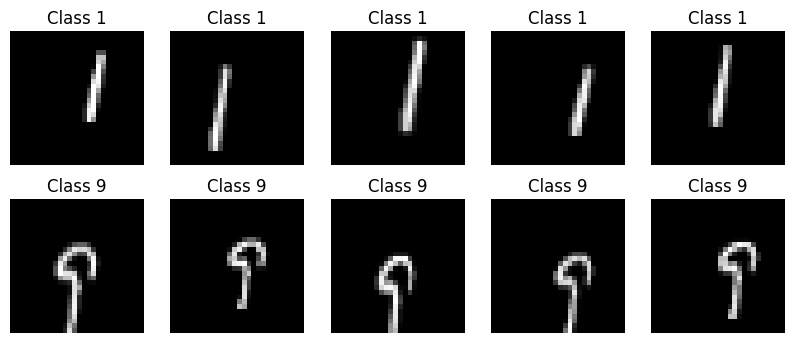

In [36]:
num1 = 1
num2 = 9
ntemp = 1
X = [10,20,40,100,200,400,800]
plot_emp_dist(X,num1,num2,ntemp)

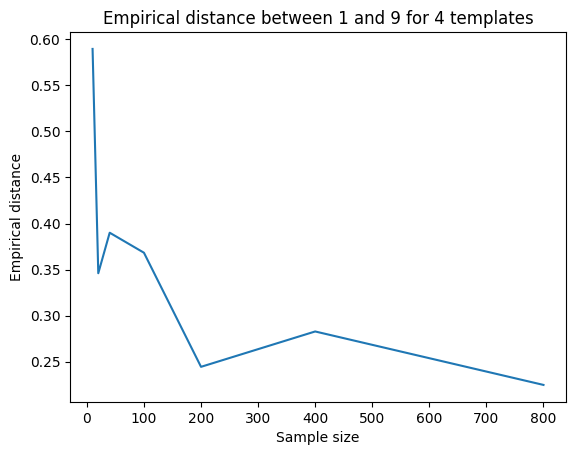

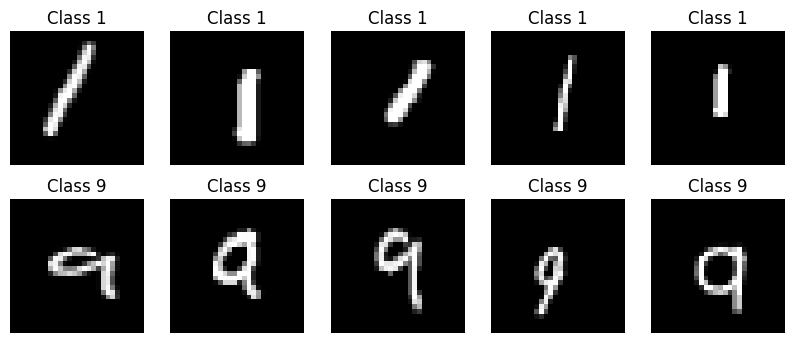

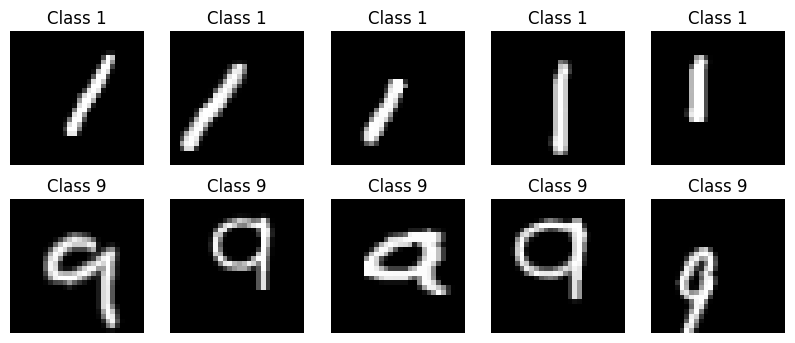

In [38]:
num1 = 1
num2 = 9
ntemp = 4
X = [10,20,40,100,200,400,800]
plot_emp_dist(X,num1,num2,ntemp)

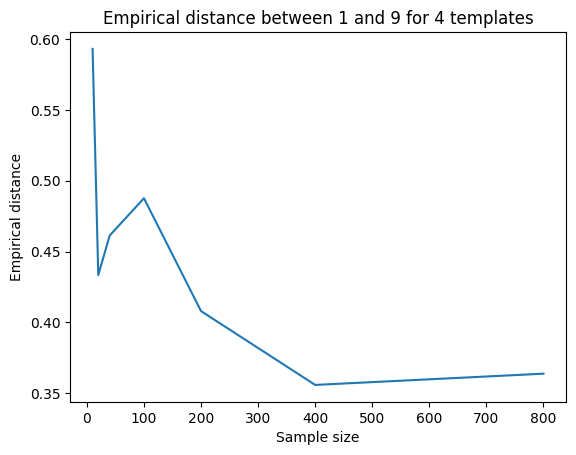

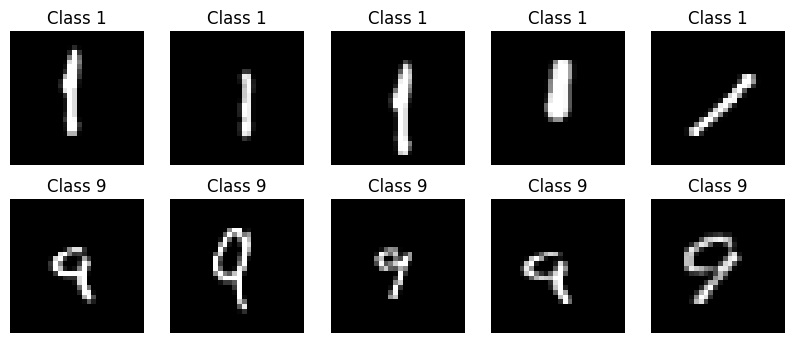

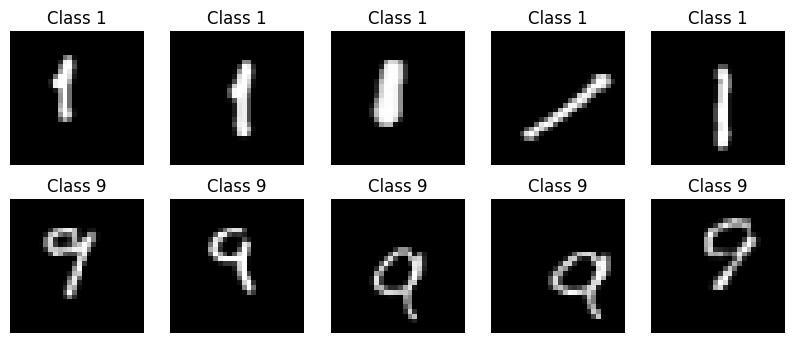

In [39]:
num1 = 1
num2 = 9
ntemp = 4
X = [10,20,40,100,200,400,800]
plot_emp_dist(X,num1,num2,ntemp)

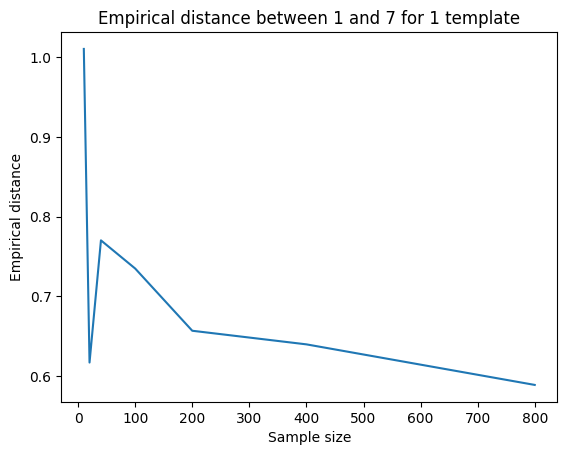

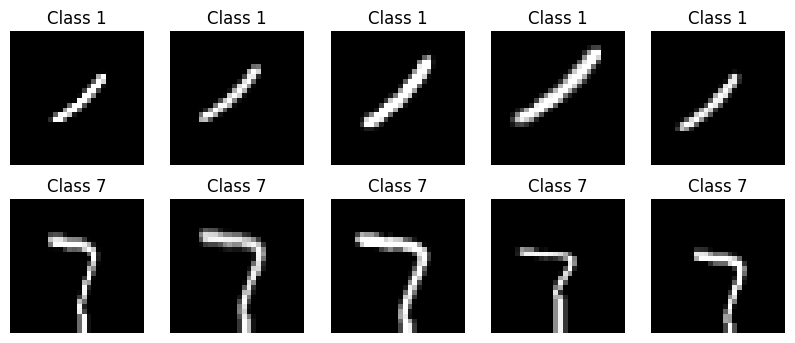

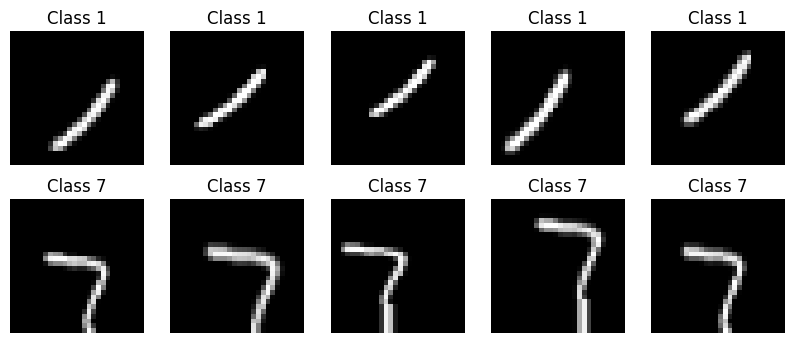

In [40]:
num1 = 1
num2 = 7
ntemp = 1
X = [10,20,40,100,200,400,800]
plot_emp_dist(X,num1,num2,ntemp)

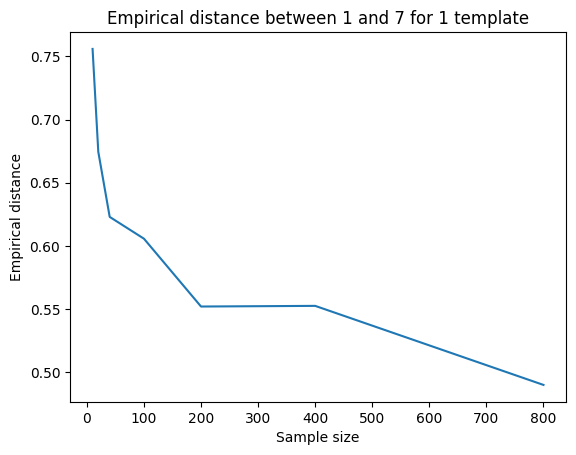

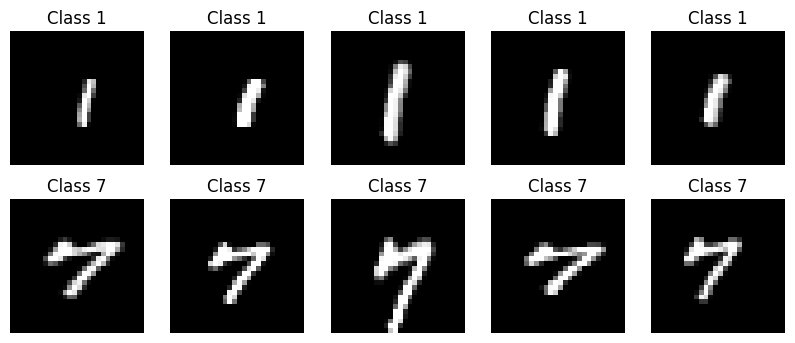

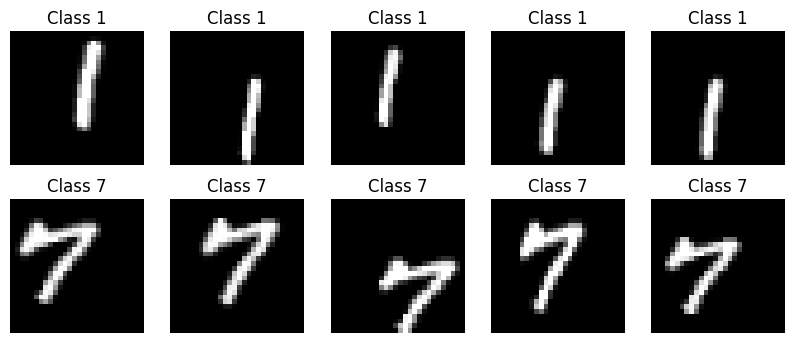

In [41]:
num1 = 1
num2 = 7
ntemp = 1
X = [10,20,40,100,200,400,800]
plot_emp_dist(X,num1,num2,ntemp)

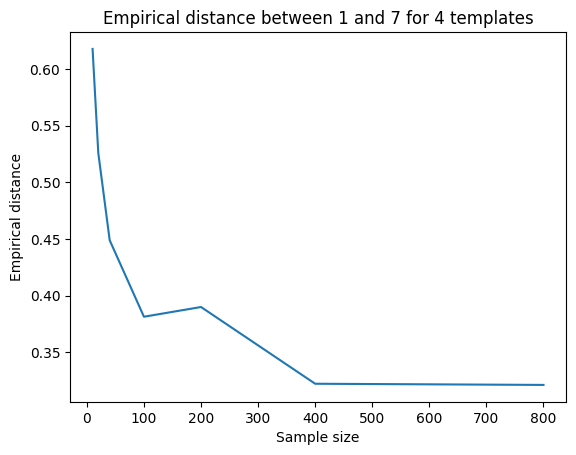

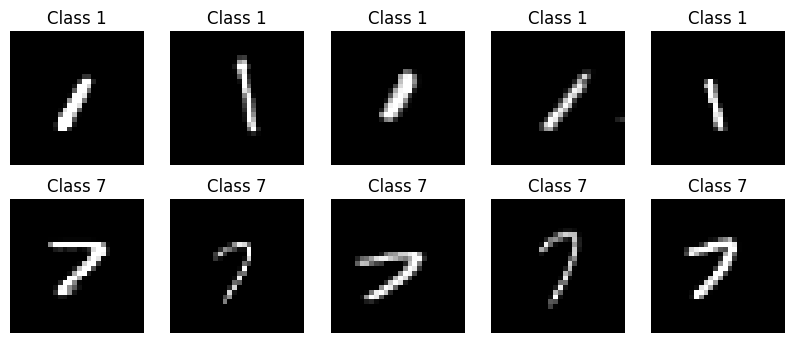

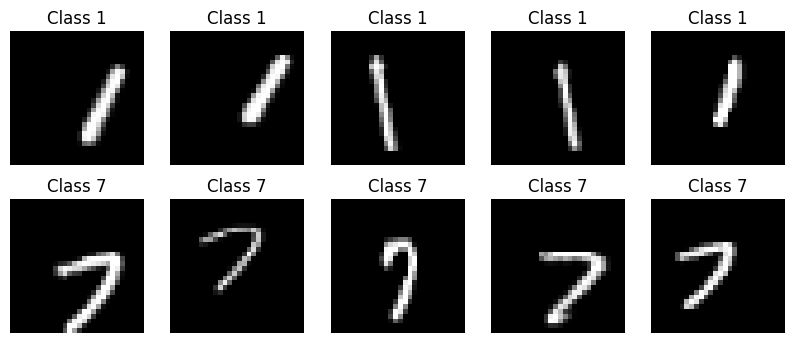

In [42]:
num1 = 1
num2 = 7
ntemp = 4
X = [10,20,40,100,200,400,800]
plot_emp_dist(X,num1,num2,ntemp)

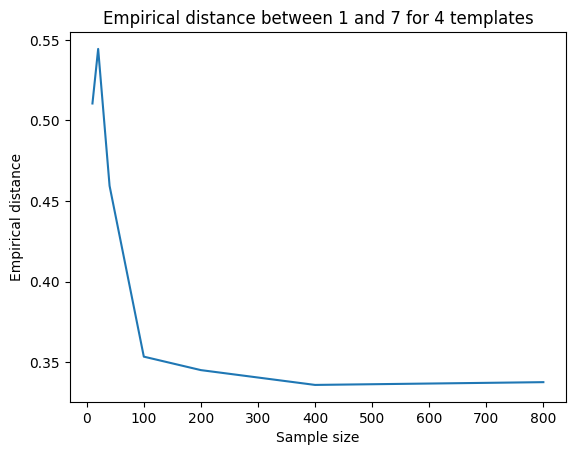

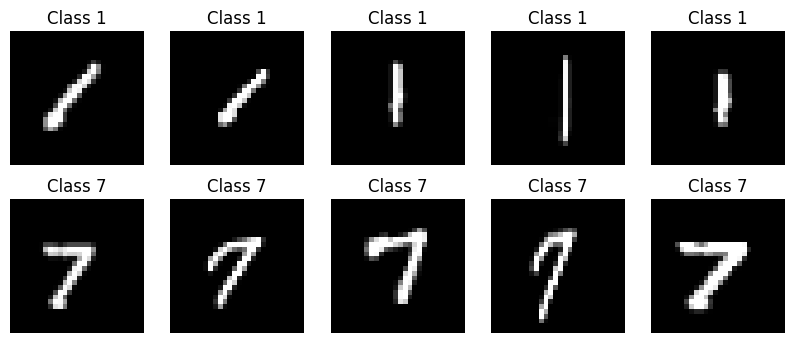

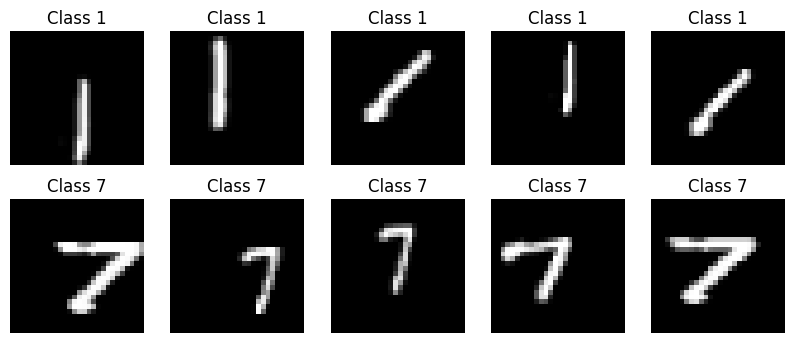

In [43]:
num1 = 1
num2 = 7
ntemp = 4
X = [10,20,40,100,200,400,800]
plot_emp_dist(X,num1,num2,ntemp)

# Defining our estimators

# Image alignment classifier

In [ ]:
# Estimator 1: Image alignment
#compute the rectangular support
def rec_support(pixels):
    """
    Computes the rectangular bounding box of the non-zero elements in a 2D binary array.
    
    Args:
        pixels: A 2D binary array (e.g., image) where non-zero elements represent pixels of the object.
        
    Returns:
        list: [i_min, i_max, j_min, j_max] indicating the bounds of the rectangle:
              - i_min, i_max: Row indices of the top and bottom bounds.
              - j_min, j_max: Column indices of the left and right bounds.

    UNCHANGED
    """
    # Compute row-wise bounds (min and max indices of non-zero elements)
    row_indices = np.any(pixels > 0, axis=1)
    i_min = np.argmax(row_indices)  # First row with non-zero element
    i_max = len(row_indices) - 1 - np.argmax(row_indices[::-1])  # Last row with non-zero element

    # Compute column-wise bounds (min and max indices of non-zero elements)
    col_indices = np.any(pixels > 0, axis=0)
    j_min = np.argmax(col_indices)  # First column with non-zero element
    j_max = len(col_indices) - 1 - np.argmax(col_indices[::-1])  # Last column with non-zero element

    return [i_min, i_max, j_min, j_max]

In [ ]:
def Z(pixels):
    """
    Transforms the given pixel array into a normalized feature matrix Z.
    
    Args:
        pixels (numpy.ndarray): A 2D array of pixel intensities.
        
    Returns:
        numpy.ndarray or None: The normalized feature matrix Z, or None if the input is invalid.

    UNCHANGED
    """
    size = pixels.shape[0]
    Z = np.zeros((size, size))
    i_min, i_max, j_min, j_max = rec_support(pixels)

    # Check for invalid support
    if i_min == 0 or i_max == size or j_min == 0 or j_max == size or j_min==0:
        return None

    # Generate Z matrix and collect non-zero pixel values
    values = []
    seq = [x/size for x in range(0, size)]

    for t1 in seq:
        for t2 in seq:
            i=math.ceil(i_min+t1*(i_max - i_min))
            j=math.ceil(j_min+t2*(j_max-j_min))
            n1 = int(t1 * size)
            n2 = int(t2 * size)
            Z[n1, n2] = pixels[i, j]
            values.append(pixels[i, j])
    # Normalize Z using the norm of pixel values
    norm_value = np.linalg.norm(Z)
    if norm_value > 0:
        Z /= norm_value

    return Z

In [ ]:
# #missclassification loss
def loss_est1(X_train, Y_train, X_test, Y_test):
    """
    Estimates the classification loss using the image alignment approach.
    
    Args:
        X_train (numpy.ndarray): List of training images.
        Y_train (numpy.ndarray): Corresponding labels for training images.
        X_test (numpy.ndarray): List of test images.
        Y_test (numpy.ndarray): Corresponding labels for test images.
        
    Returns:
        float: The average misclassification loss (float).

    MODIFIED
    """
    n = len(X_test)
    loss = 0
    misclassified_images = np.asarray([])

    # Precompute Z-transform for training set
    transformed_train = []
    for x_train in X_train:
        z_train = Z(x_train)
        transformed_train.append(z_train if z_train is not None else None)

    for i, x in enumerate(X_test):
        z_x = Z(x)
        if z_x is None:
            continue

        # Find the closest training example in Z-space
        min_dist = float('inf')
        predicted_label = None

        for j, z_train in enumerate(transformed_train):
            if z_train is None:
                continue

            dist = np.linalg.norm(z_train - z_x)
            if dist < min_dist:
                min_dist = dist
                predicted_label = Y_train[j]

        # Increment loss if prediction is incorrect
        if predicted_label != Y_test[i]:
            loss += 1
            if loss == 1:
                misclassified_images = np.asarray([X_test[i]])
            else:
                misclassified_images = np.append(misclassified_images,np.asarray([X_test[i]]),axis = 0)

    return loss / n, misclassified_images

## First CNN classifier

In [ ]:
# CNN classifier

def CNN(X_train, Y_train, X_test, Y_test):
    """
    Trains a Convolutional Neural Network (CNN) with 1 convolutional layer with
    filter size 32 x 32, one max-pooling layer with patch size 2 x 2 and one
    fully connected layer with 128 neurons. Then evaluates its performance.
    
    Args:
        X_train (numpy.ndarray): Training images.
        Y_train (numpy.ndarray): Labels for the training images
        X_test (numpy.ndarray): Test images.
        Y_test (numpy.ndarray): Labels for the test images.
        
    Returns:
        tuple: Average misclassification loss (float) and a list of misclassified test images (list).

    UNCHANGED
    """
    misclassified_images = []
    image_dim = X_train[0].shape[0]
    
    # Preprocessing: Reshape and normalize inputs
    X_train = np.reshape(X_train,(len(X_train), image_dim, image_dim, 1)) / 255.0
    X_test=np.reshape(X_test,(len(X_test), image_dim, image_dim, 1)) / 255.0
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)

    # Model Architecture
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(image_dim, image_dim, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=2)

    # Evaluate misclassification loss
    loss = 0
    for i in range(len(X_test)):
        # Predict for each test image
        pred = model.predict(X_test[i].reshape(1, image_dim, image_dim, 1), verbose=0)
        predicted_label = np.argmax(pred)
        
        if predicted_label != Y_test[i]:
            loss += 1
            if loss == 1:
                misclassified_images = np.asarray([X_test[i]])
            else:
                misclassified_images = np.append(misclassified_images,np.asarray([X_test[i]]),axis = 0)

    # Normalize loss to calculate misclassification rate
    misclassification_loss = loss / len(X_test)
    
    return misclassification_loss, misclassified_images

# Second CNN classifier

In [ ]:
def CNN1(X_train, Y_train, X_test, Y_test):
    """
    Trains a Convolutional Neural Network (CNN) with 3 convolutional layer and filter sizes
    32 x 32, 64 x 64 and 128 x 128 respectively, one max-pooling layer of patch size 2 x 2 and one
    fully connected layer with 128 neurons. Then evaluates its performance.

    Args:
        X_train (numpy.ndarray): Training images.
        Y_train (numpy.ndarray): Labels for the training images.
        X_test (numpy.ndarray): Test images.
        Y_test (numpy.ndarray): Labels for the test images.

    Returns:
        tuple: Misclassification loss (float) and a list of misclassified test images.

    UNCHANGED
    """
    misclassified_images = []
    image_dim = X_train[0].shape[1]
    
    # Reshape and normalize the datasets
    X_train = np.reshape(X_train,(len(X_train), image_dim, image_dim, 1)) / 255.0
    X_test=np.reshape(X_test,(len(X_test), image_dim, image_dim, 1)) / 255.0
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)

    # Define the CNN model
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_dim, image_dim, 1)),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=2)

    # Evaluate the model on the test set
    misclassification_count = 0
    for i in range(len(X_test)):
        pred = model.predict(X_test[i].reshape(1, image_dim, image_dim, 1), verbose=0)
        predicted_label = np.argmax(pred)
        
        if predicted_label != Y_test[i]:
            misclassification_count += 1
            if misclassification_count == 1:
                misclassified_images = np.asarray([X_test[i]])
            else:
                misclassified_images = np.append(misclassified_images,np.asarray([X_test[i]]),axis = 0)

    # Calculate misclassification loss
    misclassification_loss = misclassification_count / len(X_test)

    return misclassification_loss, misclassified_images

## Third CNN classifier

In [ ]:
def CNN2(X_train, Y_train, X_test, Y_test):
    """
    Trains a Convolutional Neural Network (CNN) with 3 convolutional layer and filter sizes
    32 x 32, 64 x 64 and 128 x 128 respectively, one max-pooling layer of patch size 2 x 2 and two fully
    connected layer and two fully connected layers with 256 and 128 neurons respectively.
    Then evaluates its performance.

    Args:
        X_train (numpy.ndarray): Training images.
        Y_train (numpy.ndarray): Labels for the training images.
        X_test (numpy.ndarray): Test images.
        Y_test (numpy.ndarray): Labels for the test images.

    Returns:
        tuple: Misclassification loss (float) and a list of misclassified test images.

    UNCHANGED
    """
    misclassified_images = []
    image_dim = X_train[0].shape[1]
    
    # Reshape and normalize the datasets
    X_train = np.reshape(X_train,(len(X_train), image_dim, image_dim, 1)) / 255.0

    X_test=np.reshape(X_test,(len(X_test), image_dim, image_dim, 1)) / 255.0
   
    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)

    # Define the CNN model
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_dim, image_dim, 1)),
        Conv2D(64, (3, 3), activation='relu'),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),  # Added Dropout for regularization
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    model.fit(X_train, Y_train, epochs=10, batch_size=32, verbose=2)

    # Evaluate the model on the test set
    misclassification_count = 0
    for i in range(len(X_test)):
        pred = model.predict(X_test[i].reshape(1, image_dim, image_dim, 1), verbose=0)
        predicted_label = np.argmax(pred)
        
        if predicted_label != Y_test[i]:
            misclassification_count += 1
            if misclassification_count == 1:
                misclassified_images = np.asarray([X_test[i]])
            else:
                misclassified_images = np.append(misclassified_images,np.asarray([X_test[i]]),axis = 0)

    # Calculate misclassification loss
    misclassification_loss = misclassification_count / len(X_test)

    return misclassification_loss, misclassified_images

# Training and plotting our missclassification

In [ ]:
def loss_med(rep, n_train, n_test, num1, num2, ntemp = 1,mask1=[],mask2=[]):
    """
    Computes the median and interquartile range (IQR) for loss values of the four estimators, 
    i.e., three different CNN structures and the image alignment classifier.

    Args:
        rep (int): Number of repetitions for generating data and computing losses.
        n_train (int): Number of training images.
        n_test (int): Number of test images.
        num1, num2 (int): The two different labels for the classes in the 
        classification problem.

    Returns:
        tuple: Medians and interquartile ranges for the losses of four estimators, empirical distance and list of misclassified images

    MODIFIED
    """
    #--------------PRELIMINARY COMPUTATIONS--------------

    n_train = math.ceil(n_train/ntemp)
    n_test = math.ceil(n_test/ntemp)
    # Load MNIST data
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()

    # Filter data for the two specific classes (using only one image per class)
    filter1 = np.where(Y_train == num1)[0]
    filter2 = np.where(Y_train == num2)[0]

    #Sample random templates from all possible templates
    if (mask1 == []) or (len(mask1) != ntemp):
        mask1 = random.sample(range(len(filter1)),ntemp)
    if (mask2 == []) or (len(mask2) != ntemp):
        mask2 = random.sample(range(len(filter2)),ntemp)

    losses = {1: [], 2: [], 3: [], 4: []}
    misclass = {1: [], 2: [], 3: [], 4: []}
    dist = emp_dist(100,num1,num2,ntemp)
    # Compute losses for each repetition
    for _ in range(rep):
        X_train, Y_train, X_test, Y_test = generate_data_mult(n_train, n_test, num1, num2, ntemp, mask1, mask2)

        res_loss_est = loss_est1(X_train, Y_train, X_test, Y_test)
        res_CNN = CNN(X_train, Y_train, X_test, Y_test)
        res_CNN1 = CNN1(X_train, Y_train, X_test, Y_test)
        res_CNN2 = CNN2(X_train, Y_train, X_test, Y_test)
        
        losses[1].append(res_loss_est[0])
        losses[2].append(res_CNN[0])
        losses[3].append(res_CNN1[0])
        losses[4].append(res_CNN2[0])

        #print("---------------------------------")
        #print(res_loss_est[1])
        if len(res_loss_est[1]) != 0:
            if len(misclass[1]) == 0:
                misclass[1] = res_loss_est[1]
            else:
                np.append(misclass[1],res_loss_est[1],axis = 0)
        if len(res_CNN[1]) != 0:
            if len(misclass[2]) == 0:
                misclass[2] = res_CNN[1]
            else:
                np.append(misclass[2],res_CNN[1],axis = 0)
        if len(res_CNN1[1]) != 0:
            if len(misclass[3]) == 0:
                misclass[3] = res_CNN1[1]
            else:
                np.append(misclass[3],res_CNN1[1],axis = 0)
        if len(res_CNN2[1]) != 0:
            if len(misclass[4]) == 0:
                misclass[4] = res_CNN2[1]
            else:
                np.append(misclass[4],res_CNN2[1],axis = 0)

    # Calculate medians and interquartile ranges
    results = {}
    for key in losses:
        res_median = statistics.median(losses[key])
        q3, q1 = np.percentile(losses[key], [75, 25])
        iqr = q3 - q1
        results[key] = {"median": res_median, "iqr": iqr}

    # Extract results into returnable format
    res1, res2, res3, res4 = (results[i]["median"] for i in range(1, 5))
    iqr1, iqr2, iqr3, iqr4 = (results[i]["iqr"] for i in range(1, 5))

    return res1, res2, res3, res4, iqr1, iqr2, iqr3, iqr4, dist, misclass


In [ ]:
def summarize_diagnostics(rep, n_test, num1, num2, ntemp = 1,mask1=[],mask2=[]):
    """
    Plots the misclassification error curves for the four different 
    estimators, i.e., the three different CNN structures and the image alignment
    approach and sample sizes [2, 4, 8, 16, 32, 64] for each class

    Args:
        rep (int): Number of repetitions for generating data and computing losses.
        n_test (int): Number of test samples.
        num1, num2 (int): Class labels for the two different classes in the classification
        problem.

    Returns:
        tuple: Histories of missclassification errors for each estimator.
        plots some of the misclassified images

    MODIFIED
    """

    # Initialize variables for storing results
    history_est1, history_cnn1, history_cnn2, history_cnn3 = [], [], [], []
    iqr_est1, iqr_cnn1, iqr_cnn2, iqr_cnn3 = [], [], [], []
    misclass_est1, misclass_cnn1, misclass_cnn2, misclass_cnn3 = [], [], [], []

    # Define sample sizes
    sample_sizes = [2, 4, 8, 16, 32, 64]
    half_sample_sizes = [s // 2 for s in sample_sizes]

    # Compute losses for each sample size
    for n_train in half_sample_sizes:
        res1, res2, res3, res4, iqr1, iqr2, iqr3, iqr4, dist, misclass = loss_med(rep, n_train, n_test, num1, num2, ntemp)

        history_est1.append(res1)
        history_cnn1.append(res2)
        history_cnn2.append(res3)
        history_cnn3.append(res4)

        iqr_est1.append(iqr1)
        iqr_cnn1.append(iqr2)
        iqr_cnn2.append(iqr3)
        iqr_cnn3.append(iqr4)

        if len(misclass[1]) != 0:
            if len(misclass_est1) == 0:
                misclass_est1 = misclass[1]
            else:
                misclass_est1 = np.append(misclass_est1,misclass[1],axis = 0)
        if len(misclass[2]) != 0:
            if len(misclass_cnn1) == 0:
                misclass_cnn1 = misclass[2]
            else:
                misclass_cnn1 = np.append(misclass_cnn1,misclass[2],axis = 0)
        if len(misclass[3]) != 0:
            if len(misclass_cnn2) == 0:
                misclass_cnn2 = misclass[3]
            else:
                misclass_cnn2 = np.append(misclass_cnn2,misclass[3],axis = 0)
        if len(misclass[4]) != 0:
            if len(misclass_cnn3) == 0:
                misclass_cnn3 = misclass[4]
            else:
                misclass_cnn3 = np.append(misclass_cnn3,misclass[4],axis = 0)
            
    # Plotting the missclassification error
    fig, ax = plt.subplots(figsize = (12,9))
    if ntemp == 1:
        message = f"{num1} vs. {num2}, emp. distance: {dist}"
    else:
        message = f"{num1} vs. {num2}, emp. distance: {dist}, num templates = {ntemp}"
    plt.title(message)
    
    # Plot the histories for each estimator
    ax.plot(sample_sizes, history_est1, label='IAC', marker='o')
    ax.plot(sample_sizes, history_cnn1, label='CNN1', marker='o')
    ax.plot(sample_sizes, history_cnn2, label='CNN2', marker='o')
    ax.plot(sample_sizes, history_cnn3, label='CNN3', marker='o')

    plt.xlabel('Training Sample Size')
    plt.ylabel('Missclassification Error')
    ax.legend()
    ax.set_ylim(bottom=0)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    plt.show()

    # Plot some misclassified images

    non_empty_misclass = []
    all_titles = ["IAC","CNN1","CNN2","CNN3"]
    non_empty_titles = []
    i = 0
    for l in [misclass_est1,misclass_cnn1,misclass_cnn2,misclass_cnn3]:
        if len(l) != 0:
            non_empty_misclass += [l]
            non_empty_titles += [all_titles[i]]
        i += 1
    if len(non_empty_misclass) != 0:
        fig, ax = plt.subplots(ncols = len(non_empty_misclass),figsize = (12,4))
        i = 0
        for l in non_empty_misclass:
            #print(l[random.randint(0,len(l)-1)])
            ax[i].imshow(l[random.randint(0,len(l)-1)].reshape(28, 28), cmap="gray")
            ax[i].set_title(non_empty_titles[i])
            i += 1
        
        # Separate loop to go over all available (empty or used) suplots to remove x and y axis
        for i in range(len(non_empty_misclass)):
            ax[i].axis('off')

        #Set desired title
        fig.suptitle("Examples of misclassified images")


    return history_est1, history_cnn1, history_cnn2, history_cnn3

--------------------------------------------
0
------
0
Epoch 1/10
1/1 - 0s - 499ms/step - accuracy: 0.5000 - loss: 2.2258
Epoch 2/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 1.8279
Epoch 3/10
1/1 - 0s - 34ms/step - accuracy: 1.0000 - loss: 1.4789
Epoch 4/10
1/1 - 0s - 35ms/step - accuracy: 1.0000 - loss: 1.1467
Epoch 5/10
1/1 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.8394
Epoch 6/10
1/1 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.5790
Epoch 7/10
1/1 - 0s - 33ms/step - accuracy: 1.0000 - loss: 0.3793
Epoch 8/10
1/1 - 0s - 32ms/step - accuracy: 1.0000 - loss: 0.2387
Epoch 9/10
1/1 - 0s - 33ms/step - accuracy: 1.0000 - loss: 0.1461
Epoch 10/10
1/1 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.0885
Epoch 1/10
1/1 - 1s - 888ms/step - accuracy: 0.0000e+00 - loss: 2.3026
Epoch 2/10
1/1 - 0s - 35ms/step - accuracy: 1.0000 - loss: 1.7755
Epoch 3/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 1.0090
Epoch 4/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.2606
Epoch 5/10
1/

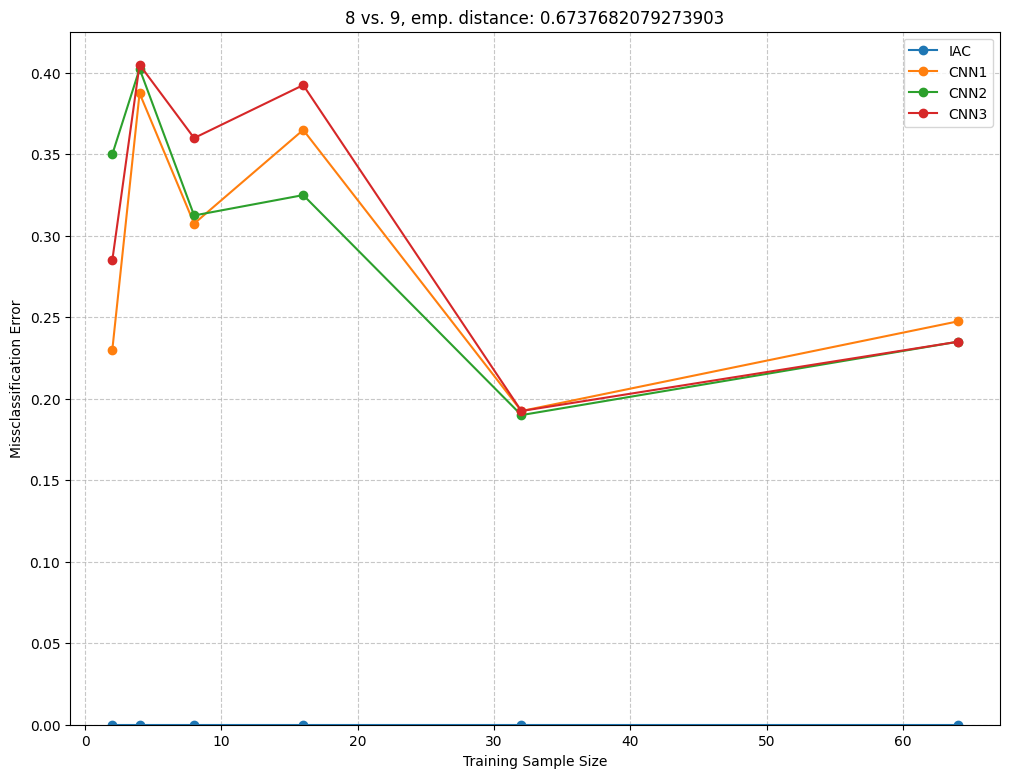

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.22999999999999998, 0.3875, 0.3075, 0.365, 0.1925, 0.2475], [0.35, 0.40249999999999997, 0.3125, 0.325, 0.19, 0.235], [0.28500000000000003, 0.405, 0.36, 0.3925, 0.1925, 0.235])


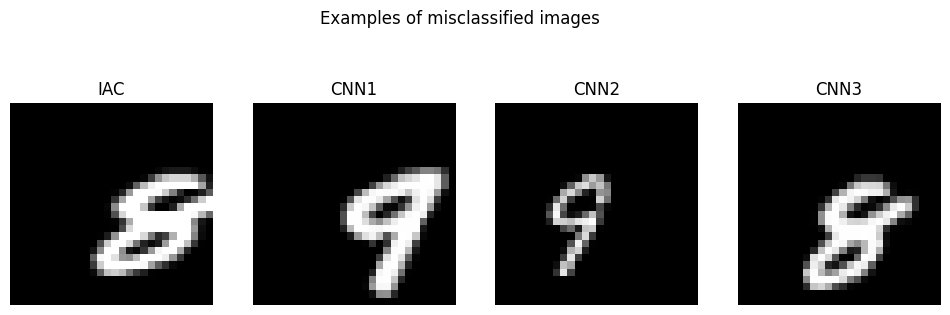

In [28]:
print(summarize_diagnostics(rep = 10, n_test = 100,  num1 = 8, num2 = 9))

In [2]:
print(summarize_diagnostics(rep = 10, n_test = 100, num1 = 8, num2 = 9, ntemp = 4))   

NameError: name 'summarize_diagnostics' is not defined

Epoch 1/10
1/1 - 1s - 560ms/step - accuracy: 0.0000e+00 - loss: 2.3130
Epoch 2/10
1/1 - 0s - 35ms/step - accuracy: 1.0000 - loss: 1.8599
Epoch 3/10
1/1 - 0s - 35ms/step - accuracy: 1.0000 - loss: 1.5196
Epoch 4/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 1.2027
Epoch 5/10
1/1 - 0s - 37ms/step - accuracy: 1.0000 - loss: 0.9238
Epoch 6/10
1/1 - 0s - 37ms/step - accuracy: 1.0000 - loss: 0.6899
Epoch 7/10
1/1 - 0s - 40ms/step - accuracy: 1.0000 - loss: 0.5055
Epoch 8/10
1/1 - 0s - 38ms/step - accuracy: 1.0000 - loss: 0.3603
Epoch 9/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.2473
Epoch 10/10
1/1 - 0s - 37ms/step - accuracy: 1.0000 - loss: 0.1627
Epoch 1/10
1/1 - 1s - 732ms/step - accuracy: 0.0000e+00 - loss: 2.3454
Epoch 2/10
1/1 - 0s - 37ms/step - accuracy: 1.0000 - loss: 1.8639
Epoch 3/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 1.2035
Epoch 4/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.5544
Epoch 5/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.1860

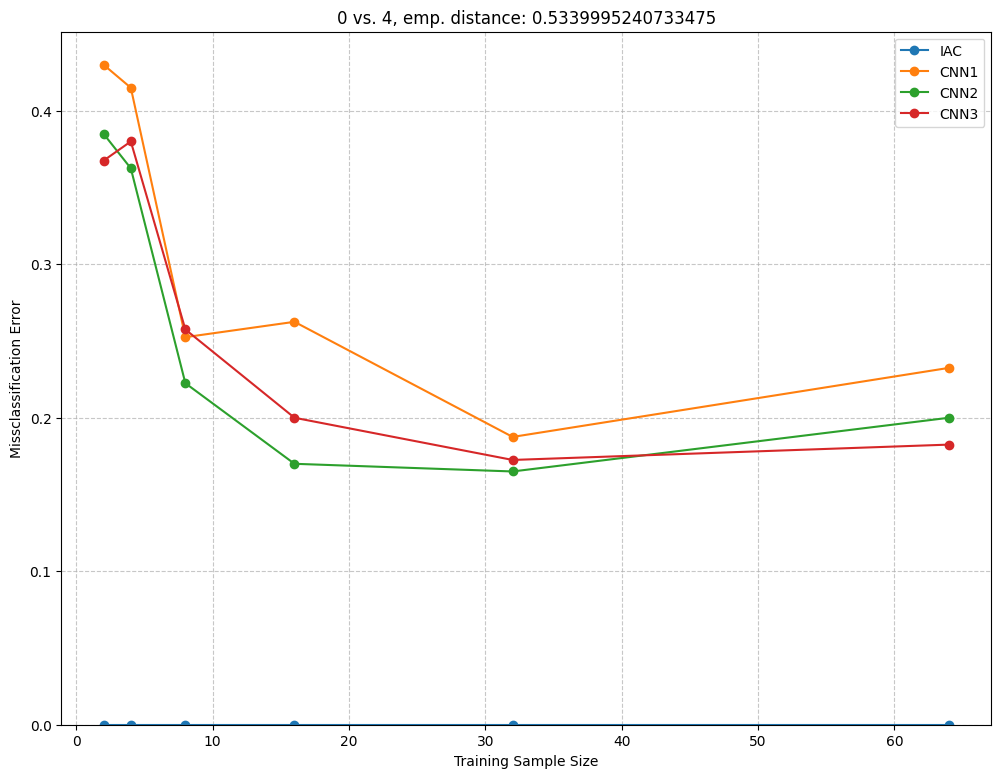

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.43, 0.415, 0.2525, 0.2625, 0.1875, 0.23249999999999998], [0.385, 0.3625, 0.2225, 0.16999999999999998, 0.165, 0.2], [0.3675, 0.38, 0.2575, 0.2, 0.1725, 0.1825])


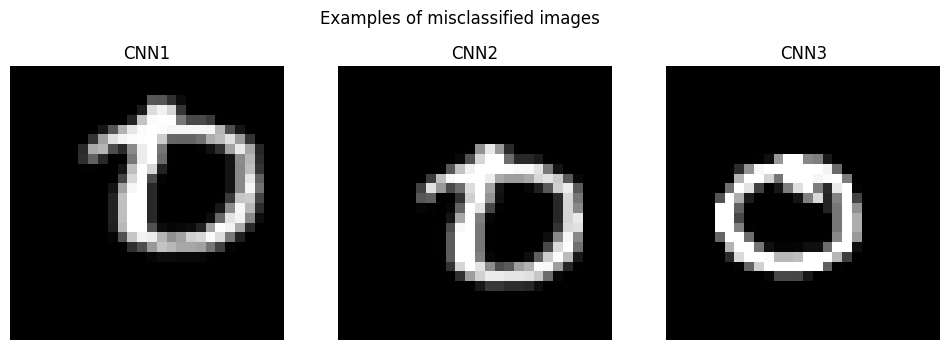

In [114]:
print(summarize_diagnostics(rep = 10, n_test = 100, num1 = 0, num2 = 4))

Epoch 1/10
1/1 - 1s - 624ms/step - accuracy: 0.3750 - loss: 2.2899
Epoch 2/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 1.8897
Epoch 3/10
1/1 - 0s - 38ms/step - accuracy: 1.0000 - loss: 1.5458
Epoch 4/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 1.2106
Epoch 5/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.9007
Epoch 6/10
1/1 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.6406
Epoch 7/10
1/1 - 0s - 34ms/step - accuracy: 1.0000 - loss: 0.4399
Epoch 8/10
1/1 - 0s - 35ms/step - accuracy: 1.0000 - loss: 0.2976
Epoch 9/10
1/1 - 0s - 37ms/step - accuracy: 1.0000 - loss: 0.2011
Epoch 10/10
1/1 - 0s - 35ms/step - accuracy: 1.0000 - loss: 0.1382
Epoch 1/10
1/1 - 1s - 738ms/step - accuracy: 0.0000e+00 - loss: 2.3018
Epoch 2/10
1/1 - 0s - 42ms/step - accuracy: 0.7500 - loss: 1.8653
Epoch 3/10
1/1 - 0s - 40ms/step - accuracy: 0.6250 - loss: 1.1937
Epoch 4/10
1/1 - 0s - 41ms/step - accuracy: 0.5000 - loss: 0.6625
Epoch 5/10
1/1 - 0s - 41ms/step - accuracy: 0.8750 - loss: 0.3561
Epo

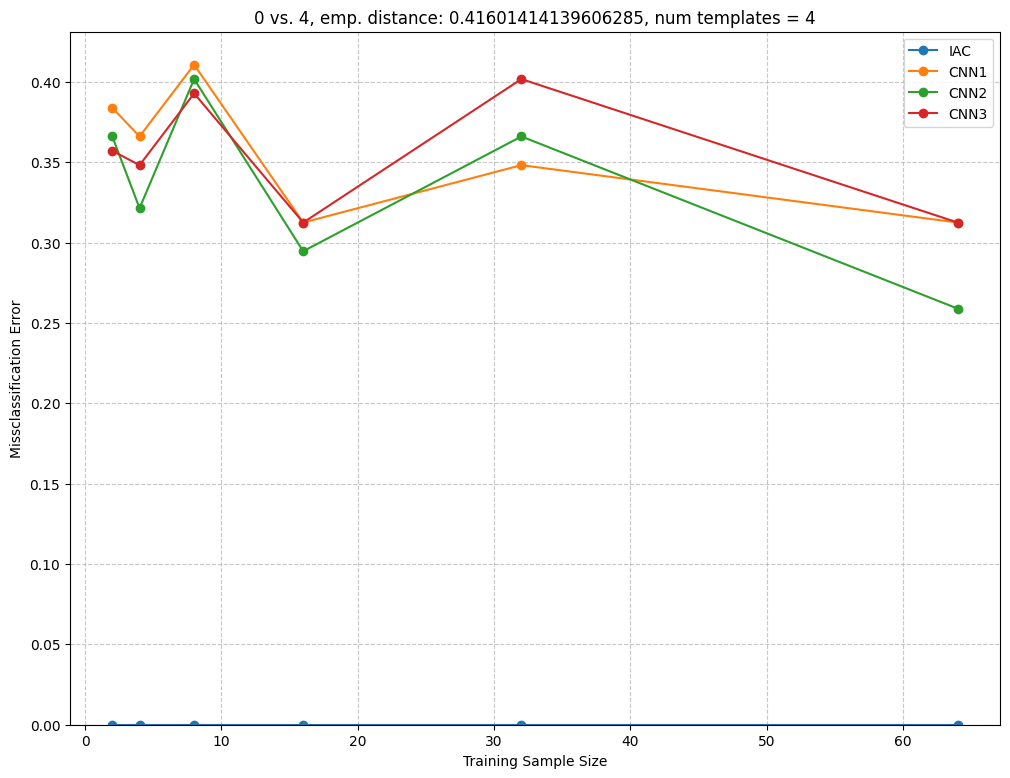

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.3839285714285714, 0.3660714285714286, 0.4107142857142857, 0.3125, 0.3482142857142857, 0.3125], [0.3660714285714286, 0.32142857142857145, 0.4017857142857143, 0.2946428571428571, 0.3660714285714286, 0.2589285714285714], [0.35714285714285715, 0.3482142857142857, 0.39285714285714285, 0.3125, 0.4017857142857143, 0.3125])


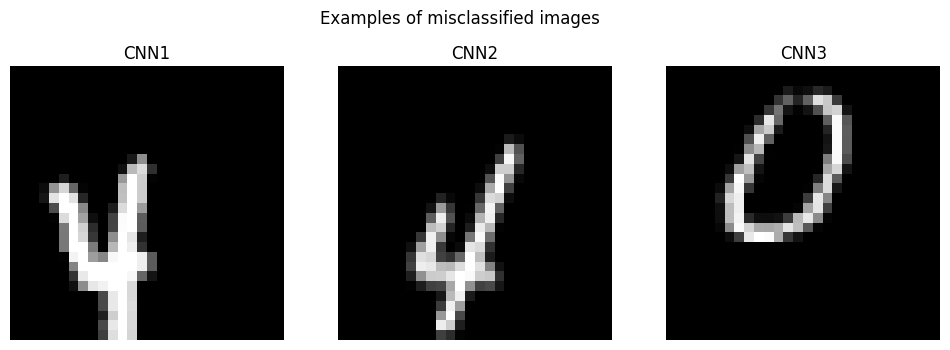

In [115]:
print(summarize_diagnostics(rep = 10, n_test = 100, num1 = 0, num2 = 4, ntemp = 4))

Epoch 1/10
1/1 - 1s - 648ms/step - accuracy: 0.5000 - loss: 2.2458
Epoch 2/10
1/1 - 0s - 38ms/step - accuracy: 1.0000 - loss: 1.8015
Epoch 3/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 1.4041
Epoch 4/10
1/1 - 0s - 43ms/step - accuracy: 1.0000 - loss: 1.0624
Epoch 5/10
1/1 - 0s - 42ms/step - accuracy: 1.0000 - loss: 0.7636
Epoch 6/10
1/1 - 0s - 41ms/step - accuracy: 1.0000 - loss: 0.5212
Epoch 7/10
1/1 - 0s - 42ms/step - accuracy: 1.0000 - loss: 0.3393
Epoch 8/10
1/1 - 0s - 38ms/step - accuracy: 1.0000 - loss: 0.2114
Epoch 9/10
1/1 - 0s - 40ms/step - accuracy: 1.0000 - loss: 0.1272
Epoch 10/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.0767
Epoch 1/10
1/1 - 1s - 740ms/step - accuracy: 0.5000 - loss: 2.2392
Epoch 2/10
1/1 - 0s - 41ms/step - accuracy: 1.0000 - loss: 1.5628
Epoch 3/10
1/1 - 0s - 37ms/step - accuracy: 1.0000 - loss: 0.7238
Epoch 4/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.2636
Epoch 5/10
1/1 - 0s - 38ms/step - accuracy: 1.0000 - loss: 0.0566
Epoch 6

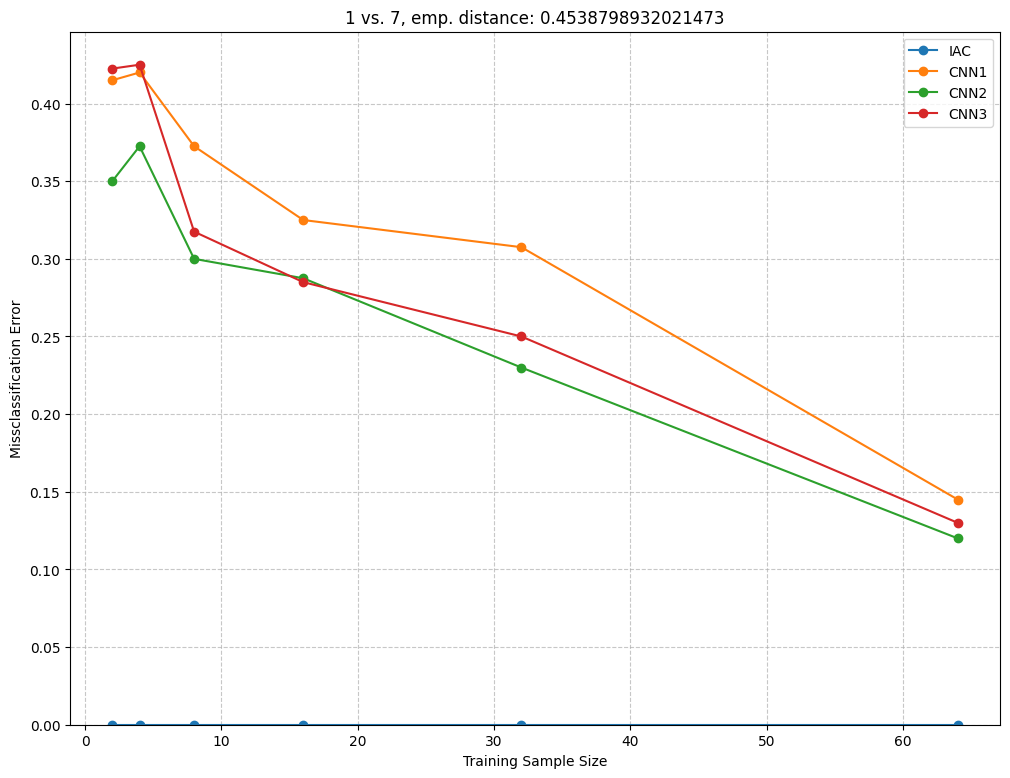

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.415, 0.42000000000000004, 0.3725, 0.325, 0.3075, 0.145], [0.35, 0.3725, 0.3, 0.2875, 0.22999999999999998, 0.12], [0.4225, 0.425, 0.3175, 0.28500000000000003, 0.25, 0.13])


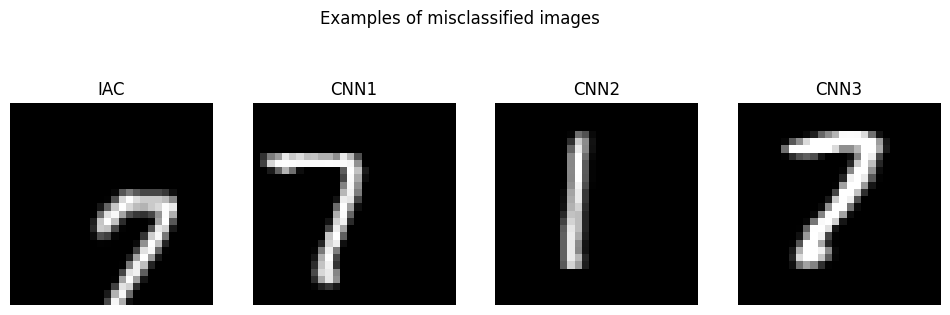

In [116]:
print(summarize_diagnostics(rep = 10, n_test = 100, num1 = 1, num2 = 7))    

Epoch 1/10
1/1 - 0s - 478ms/step - accuracy: 0.0000e+00 - loss: 2.3134
Epoch 2/10
1/1 - 0s - 38ms/step - accuracy: 0.8750 - loss: 2.0423
Epoch 3/10
1/1 - 0s - 36ms/step - accuracy: 0.8750 - loss: 1.8234
Epoch 4/10
1/1 - 0s - 35ms/step - accuracy: 0.8750 - loss: 1.5961
Epoch 5/10
1/1 - 0s - 35ms/step - accuracy: 0.8750 - loss: 1.3540
Epoch 6/10
1/1 - 0s - 36ms/step - accuracy: 0.8750 - loss: 1.1043
Epoch 7/10
1/1 - 0s - 36ms/step - accuracy: 0.8750 - loss: 0.8636
Epoch 8/10
1/1 - 0s - 36ms/step - accuracy: 0.8750 - loss: 0.6496
Epoch 9/10
1/1 - 0s - 36ms/step - accuracy: 1.0000 - loss: 0.4728
Epoch 10/10
1/1 - 0s - 35ms/step - accuracy: 1.0000 - loss: 0.3347
Epoch 1/10
1/1 - 1s - 808ms/step - accuracy: 0.0000e+00 - loss: 2.3178
Epoch 2/10
1/1 - 0s - 39ms/step - accuracy: 0.8750 - loss: 1.9713
Epoch 3/10
1/1 - 0s - 38ms/step - accuracy: 0.7500 - loss: 1.4035
Epoch 4/10
1/1 - 0s - 40ms/step - accuracy: 0.7500 - loss: 0.7715
Epoch 5/10
1/1 - 0s - 41ms/step - accuracy: 0.8750 - loss: 0.3979

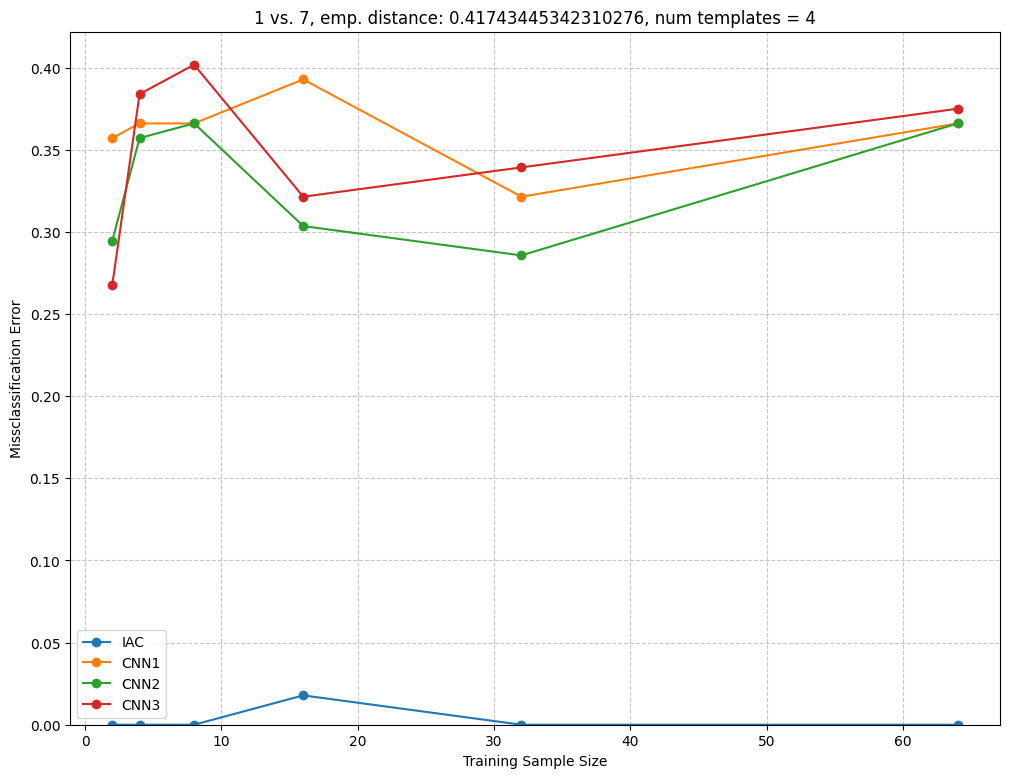

([0.0, 0.0, 0.0, 0.017857142857142856, 0.0, 0.0], [0.35714285714285715, 0.3660714285714286, 0.3660714285714286, 0.39285714285714285, 0.32142857142857145, 0.3660714285714286], [0.2946428571428571, 0.35714285714285715, 0.3660714285714286, 0.3035714285714286, 0.2857142857142857, 0.3660714285714286], [0.26785714285714285, 0.3839285714285714, 0.4017857142857143, 0.3214285714285714, 0.3392857142857143, 0.375])


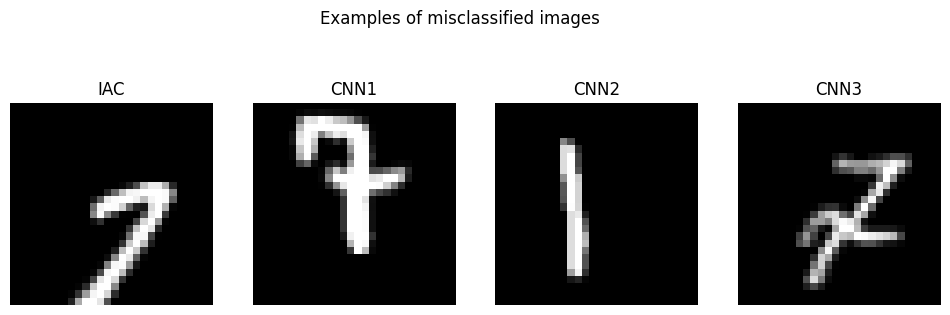

In [117]:
print(summarize_diagnostics(rep = 10, n_test = 100, num1 = 1, num2 = 7, ntemp = 4))    